In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import colors
from copy import deepcopy

from rashomon import tva

%matplotlib inline

# Read data

In [94]:
profiles, profiles_map = tva.enumerate_profiles(4)
profile_cols = [str(x) for x in profiles]
best_profile = (1, 0, 1, 0)
best_profile_idx = profiles_map[best_profile]
true_best_profile = str(best_profile)

In [222]:
# fname_csv = "../Results/reff_simulations_rashomon_25_100.csv"
# fname_csv = "../Results/reff_simulations_rashomon_25_100.csv"
# fname_csv = "../Results/reff_simulations_var_1_rashomon_10_100.csv"
fname_prefix = "4arms_"
fname_suffix = "_30_50.csv"
lasso_fname_suffix = "_30_100.csv"

## Rashomon

In [201]:

rashomon_fname_csv = "../Results/" + fname_prefix + "rashomon" + fname_suffix
rashomon_raw_df = pd.read_csv(rashomon_fname_csv)
rashomon_raw_df = rashomon_raw_df.drop("Unnamed: 0", axis=1)

# rashomon_raw_df.head()

rashomon_df = rashomon_raw_df.copy()

# compute the loss
reg = 1e-1
rashomon_df["loss"] = rashomon_df["MSE"] + reg * rashomon_df["num_pools"]

# Find whether each model identifies the true best profile or not
rashomon_df["right_best_profile"] = rashomon_df[true_best_profile]
rashomon_df["wrong_best_profile"] = 1 - rashomon_df["right_best_profile"]

# Remove all other columns
to_drop = ["num_pools", "MSE", "IOU", "min_dosage", "best_pol_diff"]
# profile_cols = ["(0, 0, 0)", "(0, 0, 1)", "(0, 1, 0)", "(0, 1, 1)",
#                 "(1, 0, 0)", "(1, 0, 1)", "(1, 1, 0)", "(1, 1, 1)"]
rashomon_df = rashomon_df.drop(to_drop, axis=1)
# rashomon_df = rashomon_df.drop(profile_cols, axis=1)

# Sort loss grouped by n_per_pol and sim_num
rashomon_df = rashomon_df.sort_values(["n_per_pol", "sim_num", "loss"], ascending=True)

# Count models within each simulation iteration
# Check if best profile is present in the first n models
grouped_df = rashomon_df.groupby(["n_per_pol", "sim_num"]).cumsum()
rashomon_df["best_profile_present"] = (grouped_df["right_best_profile"] > 0).astype(int)
rashomon_df["model_number"] = grouped_df["right_best_profile"] + grouped_df["wrong_best_profile"]

print(len(rashomon_df))

rashomon_df.head(n=10)

650


,n_per_pol,sim_num,"(0, 0, 0, 0)","(0, 0, 0, 1)","(0, 0, 1, 0)","(0, 0, 1, 1)","(0, 1, 0, 0)","(0, 1, 0, 1)","(0, 1, 1, 0)","(0, 1, 1, 1)",...,"(1, 0, 1, 1)","(1, 1, 0, 0)","(1, 1, 0, 1)","(1, 1, 1, 0)","(1, 1, 1, 1)",loss,right_best_profile,wrong_best_profile,best_profile_present,model_number
0,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.589148,1,0,1,1
57,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.688212,1,0,1,2
41,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.688481,1,0,1,3
63,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.688684,1,0,1,4
51,30,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,2.688741,0,1,1,5
25,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.688764,1,0,1,6
1,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.688813,1,0,1,7
2,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.688837,1,0,1,8
35,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.688844,1,0,1,9
3,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.688849,1,0,1,10


In [202]:
sims_failing = pd.unique(rashomon_df[rashomon_df["best_profile_present"] == 0]["sim_num"])
never_reaching = []
for sim in sims_failing:
    if 1 not in pd.unique(rashomon_df[rashomon_df["sim_num"] == sim][true_best_profile]):
        never_reaching.append(sim)

print(never_reaching)
# for sim in never_reaching:
#     print(rashomon_df[rashomon_df["sim_num"] == sim]["loss"])

[]


## Lasso

In [220]:
lasso_fname_csv = "../Results/" + fname_prefix + "lasso" + lasso_fname_suffix
lasso_raw_df = pd.read_csv(lasso_fname_csv)
lasso_raw_df = lasso_raw_df.drop("Unnamed: 0", axis=1)

# lasso_raw_df.head()

lasso_df = lasso_raw_df.copy()

# Find whether each model identifies the true best profile or not
lasso_df["right_best_profile"] = lasso_df[true_best_profile]
lasso_df["wrong_best_profile"] = 1 - lasso_df["right_best_profile"]

# Remove all other columns
to_drop = ["MSE", "IOU", "min_dosage", "best_pol_diff"]
# profile_cols = ["(0, 0, 0)", "(0, 0, 1)", "(0, 1, 0)", "(0, 1, 1)",
#                 "(1, 0, 0)", "(1, 0, 1)", "(1, 1, 0)", "(1, 1, 1)"]

lasso_df = lasso_df.drop(to_drop, axis=1)

# Sort loss grouped by n_per_pol and sim_num
lasso_df = lasso_df.sort_values(["n_per_pol", "sim_num", "L1_loss"], ascending=True)

# Count models within each simulation iteration
# Check if best profile is present in the first n models
grouped_df = lasso_df.groupby(["n_per_pol", "sim_num"]).cumsum()
lasso_df["best_profile_present"] = (grouped_df["right_best_profile"] > 0).astype(int)
# lasso_df["model_number"] = grouped_df["right_best_profile"] + grouped_df["wrong_best_profile"]

print(len(lasso_df))

lasso_df.head(n=10)

100


,n_per_pol,sim_num,L1_loss,"(0, 0, 0, 0)","(0, 0, 0, 1)","(0, 0, 1, 0)","(0, 0, 1, 1)","(0, 1, 0, 0)","(0, 1, 0, 1)","(0, 1, 1, 0)",...,"(1, 0, 0, 1)","(1, 0, 1, 0)","(1, 0, 1, 1)","(1, 1, 0, 0)","(1, 1, 0, 1)","(1, 1, 1, 0)","(1, 1, 1, 1)",right_best_profile,wrong_best_profile,best_profile_present
0,30,0,3.432294,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,30,1,3.571319,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,30,2,3.418015,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,30,3,3.479908,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,30,4,3.541674,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
5,30,5,3.420651,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
6,30,6,3.498391,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7,30,7,3.402305,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,30,8,3.487794,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
9,30,9,3.465997,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


## Causal Trees

In [216]:
# ct_fname_csv = "../Results/" + fname_prefix + "ct" + fname_suffix
# ct_raw_df = pd.read_csv(ct_fname_csv)
# ct_raw_df = ct_raw_df.drop("Unnamed: 0", axis=1)

# # lasso_raw_df.head()

# ct_df = ct_raw_df.copy()

# # Find whether each model identifies the true best profile or not
# true_best_profile = "(1, 0, 1)"
# ct_df["right_best_profile"] = ct_df[true_best_profile]
# ct_df["wrong_best_profile"] = 1 - ct_df["right_best_profile"]

# # Remove all other columns
# to_drop = ["IOU", "min_dosage", "best_pol_diff"]
# profile_cols = ["(0, 0, 0)", "(0, 0, 1)", "(0, 1, 0)", "(0, 1, 1)",
#                 "(1, 0, 0)", "(1, 0, 1)", "(1, 1, 0)", "(1, 1, 1)"]
# ct_df = ct_df.drop(to_drop, axis=1)

# # Sort loss grouped by n_per_pol and sim_num
# ct_df = ct_df.sort_values(["n_per_pol", "sim_num", "MSE"], ascending=True)

# # Count models within each simulation iteration
# # Check if best profile is present in the first n models
# grouped_df = ct_df.groupby(["n_per_pol", "sim_num"]).cumsum()
# ct_df["best_profile_present"] = (grouped_df["right_best_profile"] > 0).astype(int)
# # lasso_df["model_number"] = grouped_df["right_best_profile"] + grouped_df["wrong_best_profile"]

# print(len(ct_df))

# ct_df.head(n=10)

## Bar plot

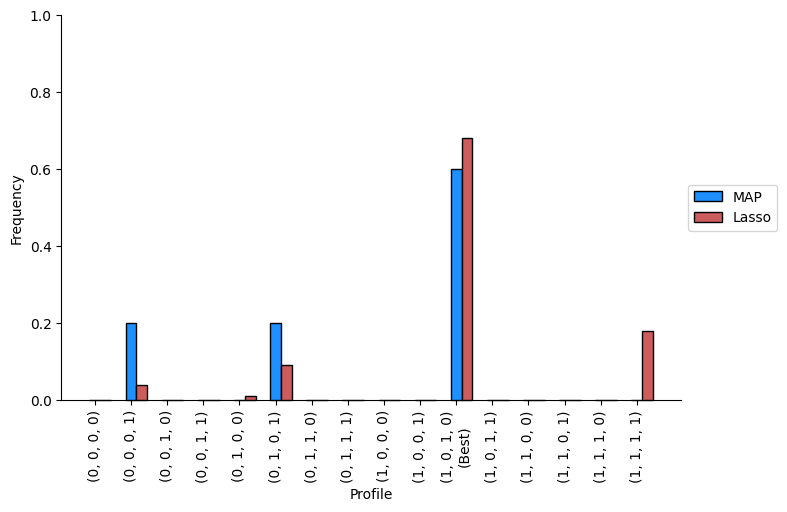

In [221]:
best_models_df = rashomon_df[rashomon_df["model_number"] == 1]

rashomon_profile_means = []
lasso_profile_means = []
ct_profile_means = []
for profile in profile_cols:
    profile_mean_col = profile + "_mean"
    rashomon_profile_means.append(np.mean(best_models_df[profile]))
    lasso_profile_means.append(np.mean(lasso_df[profile]))
    # ct_profile_means.append(np.mean(ct_df[profile]))

fig, ax = plt.subplots(figsize=(8,5))

ax.spines[['right', 'top']].set_visible(False)
profile_col_labels = deepcopy(profile_cols)
profile_col_labels[best_profile_idx] = profile_cols[best_profile_idx] + "\n(Best)"
ax.set_xticks(np.arange(len(profile_cols)), profile_col_labels, rotation=90)
ax.set_ylim(0, 1)

width = 0.3

ax.bar(np.arange(len(profile_cols)), rashomon_profile_means, width,
           color="dodgerblue", edgecolor="black", zorder=3, clip_on=False,
           label="MAP"
          )

ax.bar(np.arange(len(profile_cols)) + width, lasso_profile_means, width,
           color="indianred", edgecolor="black", zorder=3, clip_on=False,
           label="Lasso"
          )

# ax.bar(np.arange(len(profile_cols)) - width, ct_profile_means, width,
#            color="forestgreen", edgecolor="black", zorder=3, clip_on=False,
#            label="Causal Trees"
#           )

ax.set_xlabel("Profile")
ax.set_ylabel("Frequency")
# ax.set_title("Best model")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

In [204]:
print("Rashomon\t", rashomon_profile_means)
print("Lasso\t\t", lasso_profile_means)

Rashomon	 [0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0]
Lasso		 [0.0, 0.3, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0]


## Epsilon plot

In [210]:
eps_df = rashomon_df.copy()

eps_df = eps_df.drop(profile_cols, axis=1)

eps_df["eps"] = eps_df.groupby(["n_per_pol", "sim_num"])["loss"].transform(lambda x: (x - x.min()) / x.min() * 100)

# print(np.unique(eps_df["eps"]))

# eps_levels = [-0.1, 0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]
# eps_levels = [-0.1, 0, 3, 5, 7, 9, 11]
# eps_levels = [-0.1, 0, 5.2, 5.4, 5.6, 5.8, 6, 11, 12]

eps_hist = np.histogram(eps_df["eps"], bins=10)[1].tolist()
eps_levels = [-0.1] + eps_hist + [np.max(eps_df["eps"]) + 0.1]
# eps_levels = [-0.1 + np.min(eps_hist)] + eps_hist + [np.max(eps_hist) + 0.1]
eps_bins = eps_levels[1:]
eps_df["eps_levels"] = pd.cut(eps_df["eps"], bins=eps_levels, labels=eps_bins)

eps_df.head()

,n_per_pol,sim_num,loss,right_best_profile,wrong_best_profile,best_profile_present,model_number,eps,eps_levels
0,30,0,2.589148,1,0,1,1,0.000000,0.000000
57,30,0,2.688212,1,0,1,2,3.826114,3.878306
41,30,0,2.688481,1,0,1,3,3.836477,3.878306
63,30,0,2.688684,1,0,1,4,3.844344,3.878306
51,30,0,2.688741,0,1,1,5,3.846517,3.878306


In [206]:
tmp = eps_df[eps_df["eps"] > 0].groupby(["n_per_pol", "sim_num"])["eps"].transform("min")
eps_abs_min = np.min(tmp)
eps_abs_max = np.max(eps_df.groupby(["n_per_pol", "sim_num"])["eps"].transform("max"))
eps_abs_min, eps_abs_max

(3.8035260688807955, 3.8783064409219796)

In [207]:
# print(np.histogram(rashomon_df["loss"])[1].tolist())
print(eps_levels)
print("\n\n")
print("eps:", np.min(eps_df.groupby(["n_per_pol", "sim_num"])["eps"].transform("max")))

for sim in never_reaching:
    print(sim, np.max(eps_df[eps_df["sim_num"] == sim]["eps"]))

[-0.1, 0.0, 0.387830644092198, 0.775661288184396, 1.163491932276594, 1.551322576368792, 1.9391532204609898, 2.326983864553188, 2.714814508645386, 3.102645152737584, 3.4904757968297817, 3.8783064409219796, 3.9783064409219797]



eps: 3.8363112201076737


In [208]:
# eps_df["best_prof_max"] = eps_df.groupby(["n_per_pol", "sim_num", "eps_levels"], observed=False)["best_profile_present"].transform("max")

# eps_df = eps_df.drop_duplicates(["n_per_pol", "sim_num", "eps_levels", "best_prof_max"])

# eps_df["profile_rate_eps"] = eps_df.groupby(
#     ["n_per_pol", "eps_levels"], observed=False)["best_prof_max"].transform("mean")

eps_df["profile_rate_eps"] = eps_df.groupby(
    ["n_per_pol", "eps_levels"], observed=False)["best_profile_present"].transform("mean")


eps_df = eps_df.drop_duplicates(["n_per_pol", "eps_levels"])
eps_df = eps_df.drop(["sim_num", "loss", "right_best_profile", "wrong_best_profile", "best_profile_present"], axis=1)

eps_df = eps_df.sort_values("eps_levels")

eps_df

,n_per_pol,model_number,eps,eps_levels,profile_rate_eps
0,30,1,0.000000,0.000000,0.600000
57,30,2,3.826114,3.878306,0.932813


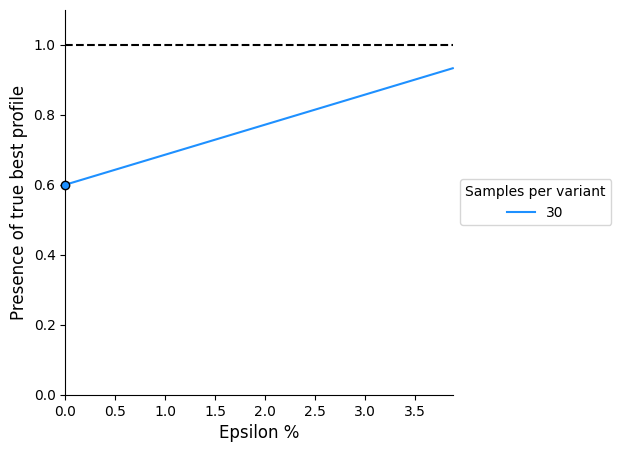

In [209]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

# sizes = [5, 10, 25, 50, 100, 250, 500, 1000]
sizes = [25]
n = 30
colors = ["dodgerblue", "indianred", "green", "orange", "orchid", "mediumseagreen", "slateblue", "slategray"]

len_x = 10
x_horizontal = np.linspace(0, np.max(eps_df["eps_levels"]), num=len_x)
y_best = np.array([1] * len_x)
# y_baseline = np.array([1/8] * len_x)
ax.plot(x_horizontal, y_best, color="black", ls="--")
# ax.plot(x_horizontal, x_horizontal / 2**24, color="grey", ls="--")

# for idx, n in enumerate(sizes):
#     n_subset = eps_df[eps_df["n_per_pol"] == n]
    
ax.plot(eps_df["eps_levels"], eps_df["profile_rate_eps"],
        color=colors[0], zorder=3.1, clip_on=False,
        label=f"{n}")
ax.scatter(eps_df["eps_levels"].iloc[0], eps_df["profile_rate_eps"].iloc[0],
           color=colors[0], edgecolor="black",
           zorder=3.1, clip_on=False)

# ax.set_xscale("log")
ax.set_xlabel("Epsilon %", fontsize=12)
ax.set_ylim(0, 1.1)
ax.set_xlim(0, np.max(eps_df["eps_levels"]))
ax.set_ylabel("Presence of true best profile", fontsize=12)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Samples per variant")

# plt.savefig("../Figures/sim_4/true_best_prof.png", dpi=300, bbox_inches="tight")
plt.show()